In [119]:
import sys
sys.path.insert(0,"/home/xlwang/NetworkCompress/src")
from net2net import *

In [23]:
train_data, validation_data = load_data(True)

"""train teacher model"""
teacher_model, history = make_teacher_model(
    train_data, validation_data,
    2,
    2
)

 X_transfer shape is:  (15770, 3, 32, 32)
Y_transfer shape is:  (15770,)
('train_logits.shape: ', (65770, 10))
('test_logits.shape: ', (10000, 10))


---------------------------------------


train_img.shape (6, 3, 32, 32) 
train_y (6, 10) test_img.shape (1, 3, 32, 32) 
test_y (1, 10) ['conv1', 'pool1', 'conv2', 'pool2', 'flatten', 'fc1', 'fc2']
Train on 6 samples, validate on 1 samples
Epoch 1/2
0s - loss: 2.3395 - acc: 0.3333 - val_loss: 2.2729 - val_acc: 0.0000e+00
Epoch 2/2
0s - loss: 2.2586 - acc: 0.3333 - val_loss: 2.2972 - val_acc: 0.0000e+00


In [ ]:
teacher_model.get_layer("conv2").get_weights()[0].shape

teacher_model.get_layer("conv2").get_weights()[1].shape

teacher_model.layers

/home/xlwang/NetworkCompress/exp


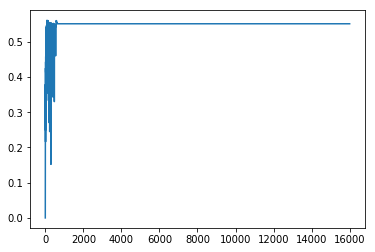

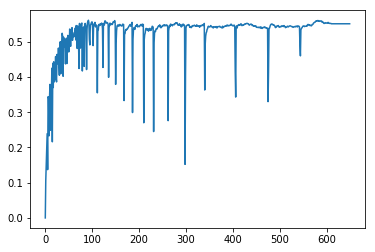

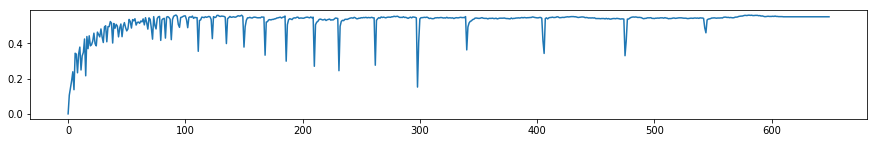

In [50]:
%cd ../exp

t=np.load("acc.npy")
plt.close("all")
plt.plot(t[0])
plt.figure()
plt.plot(t[0][:650])

plt.figure(figsize=(15,2))
plt.plot(t[0][:650])

In [ ]:
vgg_conv_width=[64,64,
                128,128,
                256,256,256,256]
vgg_fc_width=[2048,1024,10]

In [37]:
with open("debug.pkl","r") as f:
    t=cPickle.load(f)
[teacher_w1, teacher_b1, teacher_w2, new_width]=t

In [50]:
teacher_w1.shape,teacher_b1.shape,teacher_w2.shape,new_width

((64, 3, 3, 3), (64,), (64, 64, 3, 3), 128)

In [60]:
n = new_width - teacher_w1.shape[0]
index = np.random.randint(teacher_w1.shape[0], size=n)
factors = np.bincount(index)[index] + 1.
/print factors
new_w1 = teacher_w1[index, :, :, :]
new_b1 = teacher_b1[index]
new_w2 = teacher_w2[:, index, :, :] / factors.reshape((1, -1, 1, 1))

print( factors.reshape((1,-1, 1, 1)).shape)
/print factors.astype  factors.shape
student_w1 = np.concatenate((teacher_w1, new_w1), axis=0)
# add small noise to break symmetry, so that student model will have
# full capacity later
noise = np.random.normal(0, 5e-2 * new_w2.std(), size=new_w2.shape)
student_w2 = np.concatenate((teacher_w2, new_w2 + noise), axis=1)
student_w2[:, index, :, :] = new_w2
student_b1 = np.concatenate((teacher_b1, new_b1), axis=0)

[ 3.  2.  2.  2.  3.  2.  3.  2.  2.  3.  2.  3.  2.  3.  3.  2.  2.  4.
  3.  3.  3.  3.  2.  4.  3.  2.  2.  4.  3.  3.  3.  3.  4.  2.  2.  4.
  3.  4.  3.  3.  2.  3.  3.  3.  2.  4.  4.  4.  4.  2.  3.  3.  3.  2.
  2.  4.  3.  3.  2.  4.  3.  2.  3.  3.]
(1, 64, 1, 1)
<built-in method astype of numpy.ndarray object at 0x7ff0e2ddcda0> (64,)


In [62]:
student_w1.shape,student_b1.shape,student_w2.shape

((128, 3, 3, 3), (128,), (64, 128, 3, 3))

In [66]:
n = new_width - teacher_w1.shape[0]
index = np.random.randint(teacher_w1.shape[0], size=n)
factors = np.bincount(index)[index] + 1.
new_w1 = teacher_w1[index, :, :, :]/factors.reshape((-1,1,1,1))
noise = np.random.normal(0, 5e-2 * new_w1.std(), size=new_w1.shape)
student_w1 = np.concatenate((teacher_w1, new_w1+noise), axis=0)
student_w1=student_w1[index,:,:,:]=new_w1

new_b1 = teacher_b1[index]/factors
noise = np.random.normal(0, 5e-2 * new_b1.std(), size=new_b1.shape)
student_b1 = np.concatenate((teacher_b1, new_b1+noise), axis=0)
student_b1=student_b1[index]